In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue import config

from tyssue.core.generation import create_anchors

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.core.objects import get_opposite

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.stores import load_datasets

In [7]:
min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-8,    
            'gtol': 1e-8},
        }
    }


def load_before_apopto():

    h5store = 'before_apoptosis.hf5'
    #h5store = 'small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    specs = config.geometry.sheet_spec()
    sheet = Sheet('emin', datasets, specs)
    geom.update_all(sheet)

    # ## Remove dead cells at boundary
    boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
    for cell in boundary_cells:
        remove_face(sheet, cell)

    sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

    sheet.vert_df.is_active = 1
    create_anchors(sheet)
    
    nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
    nondim_specs['edge']['anchor_tension'] = 0.3
    dim_model_specs = model.dimentionalize(nondim_specs)
    sheet.update_specs(dim_model_specs, reset=True)

    # sheet.vert_df.loc[dead_src, 'is_active'] = 0
    return sheet

sheet = load_before_apopto()
geom.update_all(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


In [4]:
vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


In [8]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


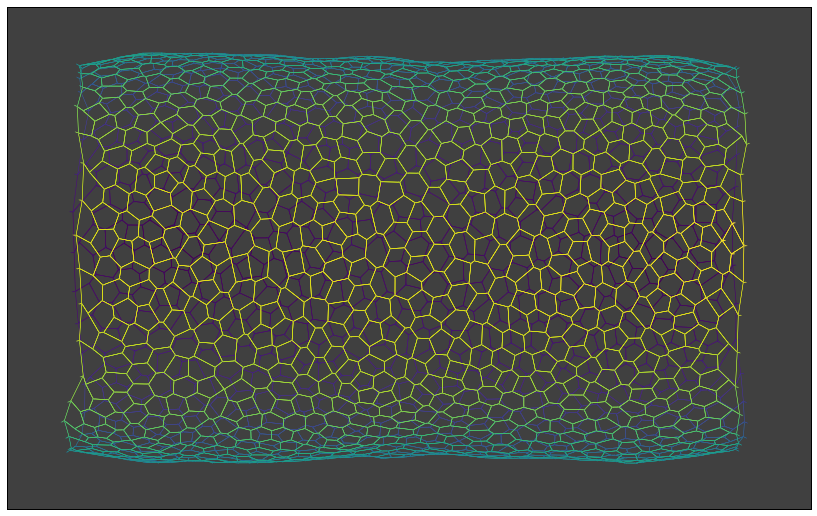

In [7]:
def leg_joint_view(sheet, coords=['z', 'y', 'x']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-50, 50)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_frame_on(False)
    fig.set_size_inches((16, 9))
    fig.set_frameon(False)
    fig.set_clip_box(ax.bbox)
    return fig, ax

fig, ax = leg_joint_view(sheet)
plt.savefig('before.png', bbox_inches='tight')

In [10]:
border_verts = sheet.vert_df[sheet.vert_df['at_border']==1]

(40, 80)

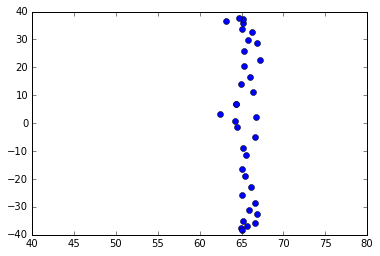

In [17]:
fig, ax = plt.subplots()
ax.plot(border_verts.z, border_verts.y, 'o')
ax.set_xlim(40, 80)

In [16]:
sheet.edge_df[sheet.edge_df['opposite']==-1]

,srce,trgt,face,length,dy,dz,ny,nx,dx,nz,sub_area,sub_vol,line_tension,opposite,at_border,is_anchor,anchor_tension
edge,,,,,,,,,,,,,,,,,
0,3327,3265,1,6.691538,6.648267,-0.691275,0.347099,12.808315,-0.315234,-2.502639,6.527569,59.240293,1410.906092,-1.0,1,0,3527.26523
149,99,100,26,4.016136,3.495107,1.940246,-0.499127,-5.071693,0.386032,1.908179,2.720861,34.643389,1410.906092,-1.0,1,0,3527.26523
150,100,101,26,3.743434,2.768513,-1.678597,-2.996810,-8.465470,-1.879082,4.533905,5.029944,68.102143,1410.906092,-1.0,1,0,3527.26523
156,3266,3328,27,7.678030,-7.243153,-0.130817,-3.384090,9.563776,-2.543967,1.387847,5.119668,66.145549,1410.906092,-1.0,1,0,3527.26523
157,3122,3266,27,2.969505,1.597382,2.500200,-2.389193,6.444999,0.123831,1.207249,3.489402,44.445325,1410.906092,-1.0,1,0,3527.26523
160,3265,3267,30,7.155992,6.936138,1.201502,2.952208,13.350126,-1.286311,-2.750316,6.973264,62.517770,1410.906092,-1.0,1,0,3527.26523
317,100,101,56,3.743434,2.768513,-1.678597,2.495903,4.158893,-1.879082,-0.539116,2.440111,33.037505,1410.906092,-1.0,1,0,3527.26523
320,3268,3266,56,9.123010,-8.851226,0.312283,4.713859,18.605916,2.188056,3.242737,9.732881,118.894787,1410.906092,-1.0,1,0,3527.26523
323,3267,3269,59,7.941737,7.367332,0.301678,5.784423,14.156414,-2.950015,-2.831262,7.776240,71.259260,1410.906092,-1.0,1,0,3527.26523


In [4]:
sheet.face_df[sheet.face_df.z > 55].index

Int64Index([  25,   26,   27,   55,   56,   83,   84,   85,  112,  113,
            ...
            1517, 1520, 1544, 1558, 1610, 1621, 1627, 1657, 1690, 1710],
           dtype='int64', name='face', length=128)

In [33]:
def prune_face(sheet, face):
    
    face_edges = sheet.edge_df[sheet.edge_df['face']==face].index
    sheet.edge_df = sheet.edge_df.loc[sheet.edge_df.index.delete(face_edges)].copy()
    sheet.face_df = sheet.face_df.loc[sheet.face_df.index.delete(face)].copy()
    verts = set(sheet.edge_df[['srce', 'trgt']].values.ravel())
    sheet.vert_df = sheet.vert_df.loc[verts].copy()
    sheet.reset_topo()
    sheet.reset_index()
    geom.update_all(sheet)
    return sheet

In [54]:
sheet = prune_face(sheet, 26)
#

In [68]:
sheet.reset_index()
sheet.reset_topo()

In [67]:
sheet.vert_df = sheet.vert_df.loc[set(sheet.edge_df['srce'])]

In [69]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


In [73]:
sheet.vert_df[sheet.vert_df['is_active']==0]

,is_active,z,x,y,old_idx,basal_shift,rho,height,radial_tension,is_anchor,at_border
vert,,,,,,,,,,,


In [53]:
%matplotlib qt

fig, ax = leg_joint_view(sheet)
ax.plot(border_verts.z, border_verts.y, 'o')

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


In [25]:
sheet.vert_df[(sheet.vert_df.z > 62.40) &
              (sheet.vert_df.z < 62.42) &
              (sheet.vert_df.y > 3.35) &
              (sheet.vert_df.y < 3.37)]

,is_active,z,x,y,old_idx,basal_shift,rho,height,radial_tension,at_border,is_anchor
vert,,,,,,,,,,,
99,1,62.412059,41.581949,3.361978,1031.0,28.985131,41.717639,12.732508,0.0,1,0


In [26]:
sheet.edge_df[sheet.edge_df.srce == 99]

,srce,trgt,face,length,dy,dz,ny,nx,dx,nz,sub_area,sub_vol,line_tension,opposite,at_border,is_anchor,anchor_tension
edge,,,,,,,,,,,,,,,,,
149,99,100,26,4.016136,3.495107,1.940246,-0.499127,-5.071693,0.386032,1.908179,2.720861,34.643389,1410.906092,-1.0,1,0,3527.26523
152,99,2924,26,0.063300,0.014502,-0.061551,0.018457,0.125937,-0.002838,-0.001457,0.063646,0.810367,1410.906092,6301.0,0,0,3527.26523
6302,99,3122,1111,3.170691,-2.618018,1.783638,-0.878297,6.204687,0.133781,-1.754544,3.253766,41.428598,1410.906092,9522.0,0,0,3527.26523
9519,99,100,1657,4.016136,3.495107,1.940246,-0.502952,9.894991,0.386032,-1.062704,4.982297,63.437138,1410.906092,-1.0,1,0,3527.26523
9925,99,3330,0,0.750708,0.033620,0.624121,0.291648,-0.003843,0.415819,-0.013150,0.145985,1.858754,1410.906092,-1.0,0,1,3527.26523
9992,99,3397,0,0.750708,0.033620,0.624121,0.291648,-0.003843,0.415819,-0.013150,0.145985,1.858754,1410.906092,-1.0,0,1,3527.26523


In [45]:
sheet.edge_df[sheet.edge_df.face == 26]

,srce,trgt,face,length,dy,dz,ny,nx,dx,nz,sub_area,sub_vol,line_tension,opposite,at_border,is_anchor,anchor_tension
edge,,,,,,,,,,,,,,,,,
149,99.0,100.0,26,4.016136,3.495107,1.940246,-0.499127,-5.071693,0.386032,1.908179,2.720861,34.643389,1410.906092,9519.0,1,0,3527.26523
150,100.0,101.0,26,3.743434,2.768513,-1.678597,-2.996810,-8.465470,-1.879082,4.533905,5.029944,68.102143,1410.906092,-1.0,1,0,3527.26523
151,2264.0,101.0,26,1.614435,0.294801,1.586467,1.900194,6.427469,0.051128,-0.560239,3.362921,40.777223,1410.906092,314.0,0,0,3527.26523
152,99.0,2924.0,26,0.063300,0.014502,-0.061551,0.018457,0.125937,-0.002838,-0.001457,0.063646,0.810367,1410.906092,6301.0,0,0,3527.26523
153,2924.0,2925.0,26,3.910526,3.177647,-2.164985,0.516113,3.850271,-0.712467,-0.509549,1.958992,24.939638,1410.906092,8952.0,0,0,3527.26523
154,2925.0,2264.0,26,3.034802,2.776670,0.901717,1.977468,6.382489,-0.828873,-0.222356,3.342753,41.462658,1410.906092,7004.0,0,0,3527.26523


In [ ]:
sheet.edge_df.loc[150, ['srce', 'trgt']] = 99, 3122 

In [52]:
sheet.edge_df[sheet.edge_df.face == 1657]

,srce,trgt,face,length,dy,dz,ny,nx,dx,nz,sub_area,sub_vol,line_tension,opposite,at_border,is_anchor,anchor_tension
edge,,,,,,,,,,,,,,,,,
9519,99.0,100.0,1657,4.016136,3.495107,1.940246,-0.502952,9.894991,0.386032,-1.062704,4.982297,63.437138,1410.906092,-1.0,1,0,3527.26523
9520,100.0,3266.0,1657,5.089288,4.515743,-2.343592,0.594108,-11.755125,0.128419,0.500622,5.890385,76.103127,1410.906092,-1.0,0,0,3527.26523
9521,3266.0,3122.0,1657,2.969505,1.597382,2.500200,-0.028403,-2.348680,0.123831,0.134473,1.176349,14.983430,1410.906092,157.0,1,0,3527.26523
9522,3122.0,99.0,1657,3.170691,2.618018,-1.783638,0.028403,2.348680,-0.133781,-0.134473,1.176349,14.983430,1410.906092,6302.0,0,0,3527.26523


In [50]:
sheet.edge_df.loc[9522, ['srce', 'trgt']] = 3122, 99


In [51]:


sheet.reset_topo()

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


In [62]:
hdf5.save_datasets('before_apoptosis_anchors.hf5', sheet)

In [31]:
sface = sheet.edge_df.groupby('face')['dx'].sum()
sface[sface > 1e-9]

face
0    18.747192
Name: dx, dtype: float64

number of apoptotic cells: 30


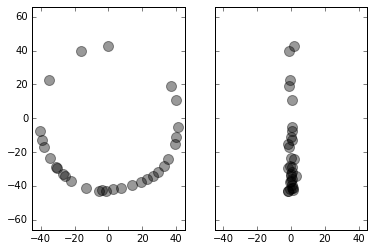

In [50]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=1.5, amp=0.7):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(sheet):

    np.random.seed(42)
    sheet.face_df['theta'] = np.arctan2(sheet.face_df['x'],
                                        sheet.face_df['y'])
    p_apopto = apopto_pdf(sheet.face_df['z'], sheet.face_df['theta'])
    rand_field = np.random.random(sheet.face_df.shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in sheet.face_df.loc[apopto_cells].sort_values('x').index
                             if sheet.face_df.loc[c, 'is_alive']])
    return apopto_cells

apopto_cells = get_apopto_cells(sheet)
print('number of apoptotic cells: {}'.format(apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[apopto_cells, 'x'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);

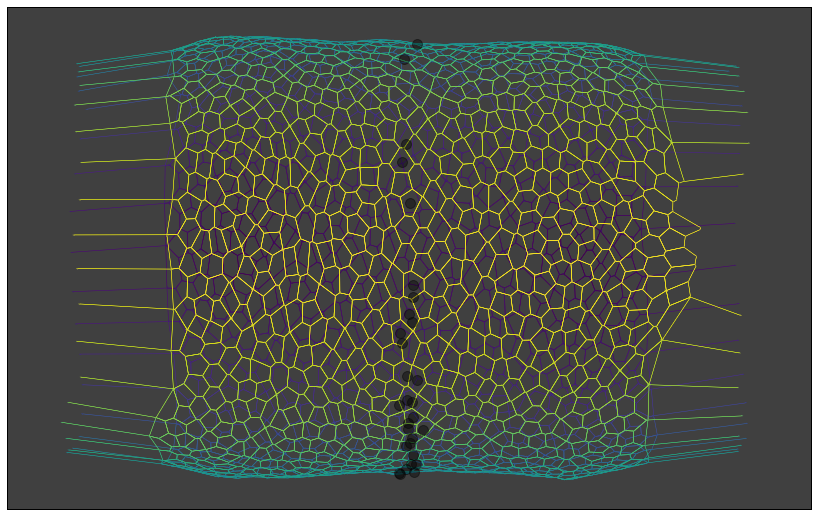

In [51]:
fig, ax = leg_joint_view(sheet)

ax.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
           sheet.face_df.loc[apopto_cells, 'y'], c='k',
           s=100, alpha=0.4)

#plt.savefig('before.png', bbox_inches='tight')

In [57]:
import logging

In [74]:
times, time_table = apoptosis_time_table(sheet, 32,
                                                 events, start_t=0)

In [75]:
time_table

ab_pull contract divide grow shrink type1_at_shorter type3
t  face                                                             
0  NaN        NaN        0    NaN  NaN    NaN              NaN   NaN
   4.0        NaN        0    NaN  NaN    NaN              NaN   NaN
   5.0        NaN        0    NaN  NaN    NaN              NaN   NaN
   6.0        NaN        0    NaN  NaN    NaN              NaN   NaN
   30.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   31.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   32.0         0      NaN    NaN  NaN      1              NaN   NaN
   33.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   34.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   57.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   58.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   59.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   60.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   61.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   85.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   87.0       NaN        0    NaN  NaN    NaN              NaN   NaN
   601.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   602.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   628.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   629.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   630.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   631.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   658.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   659.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   660.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   898.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   900.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   925.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   931.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   958.0      NaN        0    NaN  NaN    NaN              NaN   NaN
...           ...      ...    ...  ...    ...              ...   ...
29 994.0      NaN        0    NaN  NaN    NaN              NaN   NaN
   1014.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1027.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1045.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1145.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1161.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1167.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1225.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1320.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1327.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1337.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1350.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1448.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1461.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1478.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1520.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1528.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1563.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1570.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1628.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1656.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1657.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1700.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1701.0     NaN        0    NaN  NaN    NaN              NaN   NaN
   1702.0     NaN        0    NaN  NaN    NaN              NaN   NaN
30 32.0 

In [79]:
times, time_table = get_time_table(sheet, [33, 36], events)

In [81]:
time_table

ab_pull contract divide grow shrink type1_at_shorter type3
t  face                                                           
0  4        NaN        0    NaN  NaN    NaN              NaN   NaN
   5        NaN        0    NaN  NaN    NaN              NaN   NaN
   6        NaN        0    NaN  NaN    NaN              NaN   NaN
   7        NaN        0    NaN  NaN    NaN              NaN   NaN
   8        NaN        0    NaN  NaN    NaN              NaN   NaN
   30       NaN        0    NaN  NaN    NaN              NaN   NaN
   31       NaN        0    NaN  NaN    NaN              NaN   NaN
   32       NaN        0    NaN  NaN    NaN              NaN   NaN
   33         0      NaN    NaN  NaN      1              NaN   NaN
   34       NaN        0    NaN  NaN    NaN              NaN   NaN
   57       NaN        0    NaN  NaN    NaN              NaN   NaN
   58       NaN        0    NaN  NaN    NaN              NaN   NaN
   59       NaN        0    NaN  NaN    NaN              NaN   NaN
   60       NaN        0    NaN  NaN    NaN              NaN   NaN
   61       NaN        0    NaN  NaN    NaN              NaN   NaN
   87       NaN        0    NaN  NaN    NaN              NaN   NaN
   89       NaN        0    NaN  NaN    NaN              NaN   NaN
   452      NaN        0    NaN  NaN    NaN              NaN   NaN
   453      NaN        0    NaN  NaN    NaN              NaN   NaN
   454      NaN        0    NaN  NaN    NaN              NaN   NaN
   481      NaN        0    NaN  NaN    NaN              NaN   NaN
   482      NaN        0    NaN  NaN    NaN              NaN   NaN
   601      NaN        0    NaN  NaN    NaN              NaN   NaN
   630      NaN        0    NaN  NaN    NaN              NaN   NaN
   631      NaN        0    NaN  NaN    NaN              NaN   NaN
   898      NaN        0    NaN  NaN    NaN              NaN   NaN
   900      NaN        0    NaN  NaN    NaN              NaN   NaN
   925      NaN        0    NaN  NaN    NaN              NaN   NaN
   958      NaN        0    NaN  NaN    NaN              NaN   NaN
   1014     NaN        0    NaN  NaN    NaN              NaN   NaN
...         ...      ...    ...  ...    ...              ...   ...
30 1098     NaN        0    NaN  NaN    NaN              NaN   NaN
   1137     NaN        0    NaN  NaN    NaN              NaN   NaN
   1155     NaN        0    NaN  NaN    NaN              NaN   NaN
   1167     NaN        0    NaN  NaN    NaN              NaN   NaN
   1179     NaN        0    NaN  NaN    NaN              NaN   NaN
   1199     NaN        0    NaN  NaN    NaN              NaN   NaN
   1248     NaN        0    NaN  NaN    NaN              NaN   NaN
   1281     NaN        0    NaN  NaN    NaN              NaN   NaN
   1392     NaN        0    NaN  NaN    NaN              NaN   NaN
   1429     NaN        0    NaN  NaN    NaN              NaN   NaN
   1432     NaN        0    NaN  NaN    NaN              NaN   NaN
   1437     NaN        0    NaN  NaN    NaN              NaN   NaN
   1455     NaN        0    NaN  NaN    NaN              NaN   NaN
   1519     NaN        0    NaN  NaN    NaN              NaN   NaN
   1556     NaN        0    NaN  NaN    NaN              NaN   NaN
   1588     NaN        0    NaN  NaN    NaN              NaN   NaN
   1631     NaN        0    NaN  NaN    NaN              NaN   NaN
   1635     NaN        0    NaN  NaN    NaN              NaN   NaN
   1636     NaN        0    NaN  NaN    NaN              NaN   NaN
   1649     NaN        0    NaN  NaN    NaN              NaN   NaN
   1650     NaN        0    NaN  NaN    NaN              NaN   NaN
   1651     NaN        0    NaN  NaN    NaN              NaN   NaN
   1657     NaN        0    NaN  NaN    NaN              NaN   NaN
31 33       NaN      NaN    NaN  NaN    NaN                1   NaN
   36       NaN      NaN    NaN  NaN    NaN                1   NaN
32 33       NaN      NaN    NaN  NaN    NaN              NaN     1
   36       NaN      NaN    NaN  NaN    NaN            

In [83]:
    for t in times:
        face_events = time_table.loc[t]
        for face, evts in face_events.iterrows():
            for event_name, event_arg in evts.dropna().items():
                 print(face, event_name, event_arg)

4 contract 0.0
5 contract 0.0
6 contract 0.0
7 contract 0.0
8 contract 0.0
30 contract 0.0
31 contract 0.0
32 contract 0.0
33 ab_pull 0.0
33 shrink 1.0
34 contract 0.0
57 contract 0.0
58 contract 0.0
59 contract 0.0
60 contract 0.0
61 contract 0.0
87 contract 0.0
89 contract 0.0
452 contract 0.0
453 contract 0.0
454 contract 0.0
481 contract 0.0
482 contract 0.0
601 contract 0.0
630 contract 0.0
631 contract 0.0
898 contract 0.0
900 contract 0.0
925 contract 0.0
958 contract 0.0
1014 contract 0.0
1040 contract 0.0
1045 contract 0.0
1086 contract 0.0
1137 contract 0.0
1145 contract 0.0
1161 contract 0.0
1167 contract 0.0
1327 contract 0.0
1337 contract 0.0
1448 contract 0.0
1455 contract 0.0
1461 contract 0.0
1478 contract 0.0
1520 contract 0.0
1563 contract 0.0
1628 contract 0.0
1631 contract 0.0
1656 contract 0.0
1657 contract 0.0
1700 contract 0.0
1701 contract 0.0
1708 contract 0.0
4 contract 0.0
5 contract 0.0
6 contract 0.0
6 contract 0.0
7 contract 0.0
7 contract 0.0
8 contract 0

In [76]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
from tyssue.topology.sheet_topology import remove_face
import os

import logging
logger = logging.Logger('event_log')

def get_time_table(sheet, apopto_cells,
                   events):

    time_tables = []
    for strat_t, cell in enumerate(apopto_cells):

        times, time_table = apoptosis_time_table(sheet, cell,
                                                 events, start_t=strat_t)
        time_tables.append(time_table)
    time_table = pd.concat(time_tables).sort_index()
    times = time_table.index.levels[0]
    return times, time_table

def time_step(face_events, events,
              sheet, geom, model, dirname):

    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            if ((not sheet.face_df.loc[face, 'is_alive']) or
                np.isnan(sheet.face_df.loc[face, 'is_alive'])):
                logger.info('skipped: face: {}, event: {}'.format(face, event_name))
                continue
            events[event_name](face, event_arg)
            logger.info('done: face: {}, event: {}'.format(face, event_name))
    
    res = solver.find_energy_min(sheet, geom, model, **settings)


    
def run_sim(sheet, apopto_cells,
            geom, model, dirname):
    
    times, time_table = get_time_table(sheet, apopto_cells,
                                       events)
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
    
    for t in times:
        face_events = time_table.loc[t]
        time_step(face_events, events,
                  sheet, geom, model, dirname)
        fig, ax = leg_joint_view(sheet)
        figname = os.path.join(
            dirname, 'fold_formation_{:03d}.png'.format(t))
        plt.savefig(figname, bbox_inches='tight')
        plt.close(fig)
    
    logger.removeHandler(hdlr)


starting 0_lambda_0_gamma


KeyboardInterrupt: 

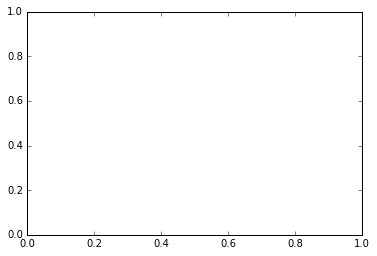

In [77]:
settings = {
    'shrink_steps': 30,
    'rad_tension': 2.0,
    'contractile_increase': 2.0,
    'contract_span': 3
    }

tensions = [0, 0, 2, 2]
contracts = [0, 2, 0, 2]
dirnames = ['{}_lambda_{}_gamma'.format(l, g)
            for l, g in zip(tensions, contracts)]

for l, g, dirname in zip(tensions, contracts, dirnames):
    
    datasets = {key: val.copy() for key, val
            in sheet.datasets.items()}
    specs = sheet.specs
    
    sheet2 = Sheet('fold', datasets, specs) # load_before_apopto()
    events = SheetEvents(sheet2, model, geom).events
    res = solver.find_energy_min(sheet2, geom, model,
                                 **min_settings)
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    settings.update(
        {'rad_tension': l,
         'contractile_increase': g})
    sheet2.settings['apoptosis'] = settings
    run_sim(sheet2, apopto_cells, 
            geom, model, dirname)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

In [ ]:
fig, ax = leg_joint_view(sheet)

In [7]:
vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
